In [1]:
import torch
import torch.nn as nn
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
import pickle
import time
import csv

In [2]:
D = []
with open('../Creating_Facial_Landmarks/Landmarks2.csv', newline='') as csvfile:
    spamreader = csv.reader(csvfile, delimiter=',', quotechar='"')
    for row in spamreader:
        d = {}
        landmarks = row[1]
        landmarks = landmarks.replace(" [", "").replace("[", "").replace(",", "")
        landmarks = landmarks.split("]")
        LL = []
        for landmark in landmarks:
            try:
                ll = [float(l) for l in landmark.split(" ")]
                LL.append(ll)
            except:
                pass
        if len(LL) > 0:
            LL = np.array(LL)
            #do the regular one
            d['landmarks'] = np.array(LL).flatten()
            d['emotion'] = row[2].replace("[", "").replace("]", "").replace("'", "")
            D.append(d)
            #do the flipped ones
            d = {}
            m = LL[:,0].mean()
            LL[:,0] = -(LL[:,0] - m) + m
            d['landmarks'] = np.array(LL).flatten()
            d['emotion'] = row[2].replace("[", "").replace("]", "").replace("'", "")
            D.append(d)

In [3]:
class MLP(nn.Module):
    def __init__(self,architecture=[1,100,1],activation='sigmoid'):
        super(MLP, self).__init__()      
        self.architecture=architecture
        if activation=='sigmoid':
            self.activation=nn.Sigmoid()
        elif activation=='relu':
            self.activation=nn.ReLU()
        else:
            print('Activation not recognized! Using LeakyReLU instead.')
            self.activation=nn.LeakyReLU()
        arch=[]
        for i in range(1,len(architecture)-1):
            arch.append(nn.Linear(architecture[i-1],architecture[i]))            
            arch.append(self.activation)
        self.basis=nn.Sequential(*arch)
        self.regressor=nn.Linear(architecture[-2],architecture[-1])

    def forward(self,f):            
        assert f.shape[1]==self.architecture[0]
        z=self.basis(f)
        out=self.regressor(z)
        return out

In [4]:
all_emotions = False
noise = False

good = ["happiness", "surprise"]
neutral = ["neutral"]
bad = ["contempt", "anger", "sadness", "disgust", "fear"]

for d in D:
    emotion = d['emotion']
    if not all_emotions:
        if emotion in good:
            d['emotion'] = "good"
        elif emotion in neutral:
            d['emotion'] = "neutral"
        elif emotion in bad:
            d['emotion'] = "bad"

In [5]:
device = "cuda"
#get specs
N = len(D)
AU_N = len(D[0]['landmarks'])
emotions = list(set([d['emotion'] for d in D]))
emotion_N = len(emotions)
emotion_dict = {}
for i in range(emotion_N):
    emotion_dict[emotions[i]] = i
print("Data points:", N)
print("Number action units:", AU_N)
print("emotions:", emotions)
print()

train_N = int(N*.7)
test_N = (N - train_N)//2
valid_N = N - test_N - train_N

idx = torch.randperm(N)
train_idx = idx[0:train_N]
test_idx = idx[train_N:-valid_N]
valid_idx = idx[train_N + valid_N:]

#format data
data = torch.zeros((N, AU_N)).type(torch.float32).to(device) #200 by 35
label = torch.zeros((N, 1)).type(torch.long).to(device) #200 by 1
for i in range(N):
    for j in range(AU_N):
        data[i, j] = D[i]["landmarks"][j]
    label[i, 0] = emotion_dict[D[i]["emotion"]]

#split into sets
train_data = data[train_idx, :]
test_data = data[test_idx, :]
valid_data = data[valid_idx, :]
train_label = label[train_idx, 0]
test_label = label[test_idx, 0]
valid_label = label[valid_idx, 0]

#print("Size training data:", train_data.cpu().numpy().shape)
#print("Size testing data:", test_data.cpu().numpy().shape)
#print("Size valid data:", valid_data.cpu().numpy().shape)
print("Size training label:", train_label.cpu().numpy().shape)
print("Size testing label:", test_label.cpu().numpy().shape)
print("Size valid label:", valid_label.cpu().numpy().shape)

Data points: 332
Number action units: 136
emotions: ['bad', 'neutral', 'good']

Size training label: (232,)
Size testing label: (50,)
Size valid label: (50,)


In [6]:
#see how many of each emotion there are in each dataset
n_dict = {}
size_dict = {}
for key in ["all","train","valid","test"]:
    n_dict[key] = {}
    size_dict[key] = 0

for i in range(len(emotions)):
    train_n = train_label.cpu().numpy().tolist().count(i)
    valid_n = valid_label.cpu().numpy().tolist().count(i)
    test_n = test_label.cpu().numpy().tolist().count(i)
    n_dict["train"][emotions[i]] = train_n
    n_dict["valid"][emotions[i]] = valid_n
    n_dict["test"][emotions[i]] = test_n
    n_dict["all"][emotions[i]] = train_n + valid_n + test_n
    size_dict["train"] += train_n
    size_dict["valid"] += valid_n
    size_dict["test"] += test_n
    size_dict["all"] += train_n + valid_n + test_n

for key in ["all","train","valid","test"]:
    print(key)
    size = size_dict[key]
    for emotion in emotions:
        n = n_dict[key][emotion]
        print("\t",emotion,":", n, ":", round(100*n/size, 2), "%")

all
	 bad : 156 : 46.99 %
	 neutral : 100 : 30.12 %
	 good : 76 : 22.89 %
train
	 bad : 115 : 49.57 %
	 neutral : 64 : 27.59 %
	 good : 53 : 22.84 %
valid
	 bad : 22 : 44.0 %
	 neutral : 18 : 36.0 %
	 good : 10 : 20.0 %
test
	 bad : 19 : 38.0 %
	 neutral : 18 : 36.0 %
	 good : 13 : 26.0 %


In [7]:
objective = torch.nn.CrossEntropyLoss()
n_epochs = 50000
lr = 0.005
batch_size = 20
batch_num = train_N//batch_size
#arch = [AU_N, 100, 50, emotion_N]
arch = [AU_N, 200, 200, 150, 100, 50, emotion_N]
#arch = [AU_N, 100, emotion_N]
model = MLP(arch)
model.to(device)
optim=torch.optim.Adam(model.parameters(),lr=lr)

In [8]:
def transform(batch_data):
    if noise:
        batch_data = batch_data + torch.randn(batch_data.shape).to(device)*.2
    return batch_data

def accuracy(pred, label):
    pred = pred.cpu().detach().numpy()
    label = label.cpu().detach().numpy()
    pred_label = np.argmax(pred, axis = 1)
    return (label == pred_label).mean()

In [9]:
train_losses = []
valid_losses = []

start_time = time.time()
for n in range(n_epochs):
    #make batch
    batch_idx = torch.randperm(train_N)[0:batch_size]
    batch_data = train_data[batch_idx, :]
    batch_data = transform(batch_data)
    batch_label = train_label[batch_idx]
    #make prediction
    batch_pred = model(batch_data)
    #get loss
    train_loss = objective(batch_pred, batch_label)
    train_losses.append(train_loss.item())
    #optimizer step
    optim.zero_grad()
    train_loss.backward()
    optim.step()
    #do valid losses
    with torch.no_grad():
        valid_pred = model(valid_data)
        valid_loss = objective(valid_pred, valid_label)
        valid_losses.append(valid_loss.item())
end_time = time.time()
print(end_time - start_time, "seconds")

147.05373239517212 seconds


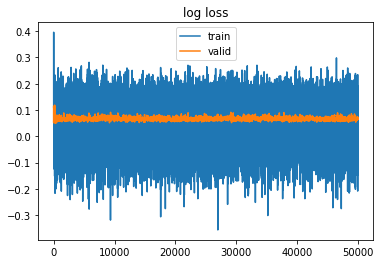

Architecture: [136, 200, 200, 150, 100, 50, 3]
Num emotions: 3
train accuracy: 0.4956896551724138
valid accuracy: 0.44
test accuracy: 0.38
Num epochs: 50000
Batch size: 20
Noise added: False


In [10]:
plt.plot(np.log(train_losses))
plt.plot(np.log(valid_losses))
plt.title("log loss")
plt.legend(["train", "valid"])
plt.show()

with torch.no_grad():
    train_pred = model(train_data)
    test_pred = model(test_data)

print("Architecture:", arch)
print("Num emotions:", emotion_N)
print("train accuracy:",accuracy(train_pred, train_label))
print("valid accuracy:",accuracy(valid_pred, valid_label))
print("test accuracy:",accuracy(test_pred, test_label))
print("Num epochs:", n_epochs)
print("Batch size:", batch_size)
print("Noise added:", noise)